# Zernike Fitting

In this notebook we will fit Zernike coefficients to measured point spread functions. 

In [56]:
# If in colab, install Jax and chromatix. Don't forget to select a GPU!
#!pip install --upgrade pip
#!pip install "jax[cuda11_cudnn82]==0.4.1" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install git+https://github.com/TuragaLab/chromatix.git

In [57]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import numpy as np

from optax import adam
import optax

import matplotlib.pyplot as plt

from chromatix.elements import ObjectivePointSource, FFLens, ZernikeAberrations
from chromatix.ops.noise import shot_noise
from chromatix.utils import trainable

from typing import Callable, Optional, Tuple

key = random.PRNGKey(42)

Before we construct our Zernike fitter, let's define some simulation parameters based on desired camera specifications.

In [58]:
camera_shape: Tuple[int, int] = (256, 256)
camera_pixel_pitch: float = 0.125
f: float = 100
NA: float = 0.8
n: float = 1.33
wavelength: float = 0.532
wavelength_ratio: float = 1.0
upsample: int = 4
pad: int = 128
crop: int = 450 # for visualization purposes
taper_width: Optional[float] = 5
noise_fn: Callable = shot_noise
shape = tuple(np.array(camera_shape) * upsample + pad)
spacing = upsample* f * wavelength/ (n * shape[0] * camera_pixel_pitch)

print(f"Shape of simulation: {shape}")
print(f"Spacing of simulation: {spacing:.2f}")

Shape of simulation: (1152, 1152)
Spacing of simulation: 1.11


# Constructing the forward model 

First we need to model how Zernike coefficients affect the PSFs. This is done by calculating the Zernike aberrations from the coefficients (given as ANSI indices).

In [59]:
# Specify "ground truth" parameters for Zernike coefficients
ansi_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
coefficients_truth = jnp.array([2.0, 5.0, 3.0, 0, 1, 0, 1, 0, 1, 0])
class ZernikePSF(nn.Module):
    @nn.compact
    def __call__(self, z):
        field = ObjectivePointSource(
            shape, spacing, wavelength, wavelength_ratio, f, n, NA, power=1e7
        )(z)
        # The only learnable parameters are the Zernike coefficients (since we use the trainable flag)
        field = ZernikeAberrations(
            trainable(jnp.array([0.0] * len(ansi_indices))), f, n, NA, ansi_indices
        )(field)
        field = FFLens(f, n)(field)
        return field 

Now, using the ZernikePSF forward model, let's generate a "measured" PSF for some "unknown" coefficients that we will ultimately like to learn.

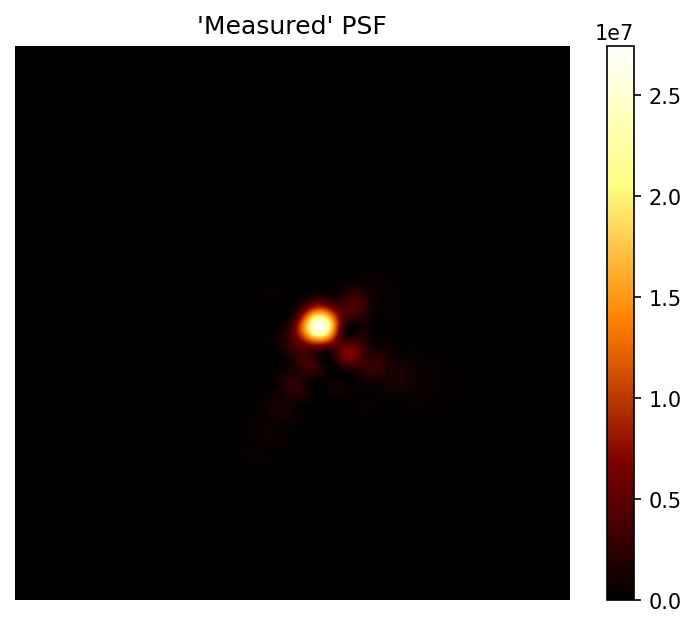

In [60]:
# Initialize model
model = ZernikePSF()
params = model.init(key, z=0)

# Set "ground truth" parameters (which will eventually try to estimate)
params_truth = {
    "params": {"ZernikeAberrations_0": {"zernike_coefficients": coefficients_truth}}
}

# Get the corresponding "measured" PSF using the true coefficients
psf_truth = model.apply(params_truth, z=0)
psf_truth = shot_noise(key, psf_truth.intensity)  # add shot noise

plt.figure(dpi=150)
plt.imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()

# Learning Zernike Coefficients 

Now that we have our target PSF, we will learn its underlying Zernike coefficients by optimizing through the forward model. First let's define a few functions needed for the training.

In [61]:
# This loss function will be our metric for measuring how close our predicted PSF is to the measured PSF. For now we
# use mean squared error.
def loss_fn(params, data, z):
    psf_estimate = model.apply(params, z=z).intensity.squeeze()
    loss = jnp.mean(jnp.square(psf_estimate - data.squeeze()))
    return loss, {"loss": loss}

grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True)) # jit compiles and makes everything go brrrrr

# The step function takes care of a single optimization step, including updating our coefficient estimate.
def step_fn(loss_fn, optimizer):
    def step(params, opt_state, *args):
        (_, metrics), grads = jax.value_and_grad(loss_fn, allow_int=True, has_aux=True)(
            params, *args
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, metrics
    return step

# We will use the adam optimizer for learning.
optimizer = adam(learning_rate=0.5)
opt_state = optimizer.init(params)
step = jax.jit(step_fn(loss_fn, optimizer)) # jit compiles and makes everything go brrrrr


Now its time to learn! We using our forward model and the optimization parameters/functions specified above we will
learn the coefficients that correspond to a PSF that best matches our measured PSF. First we display our initial guess.

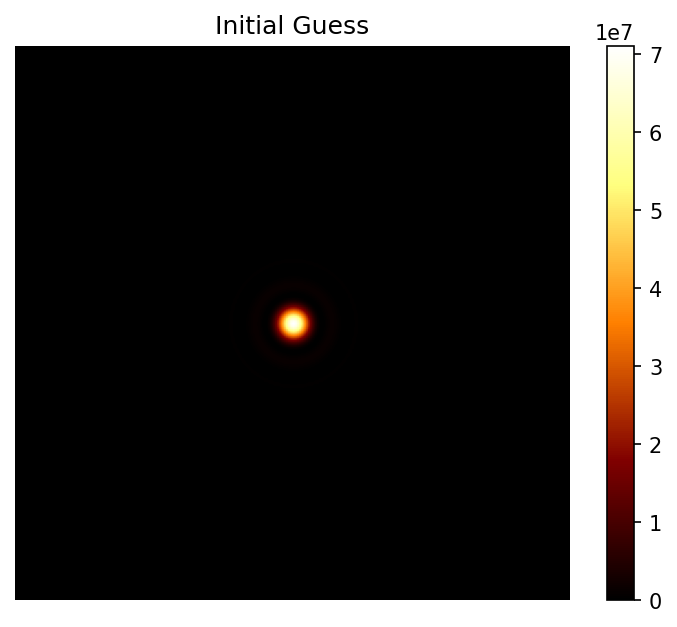

In [62]:
params = model.init(key, z=0) # dummy parameters for init
psf_init = model.apply(params, z=0).intensity.squeeze()

plt.figure(dpi=150)
plt.imshow(psf_init[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title('Initial Guess')
plt.axis("off")
plt.show()

Below is the optimization loop:

In [63]:
%%time
# Now we optimize
max_iterations = 500
print_every = 100
history = []
for iteration in range(max_iterations):
    params, opt_state, metrics = step(params, opt_state, psf_truth, 0)
    history.append(metrics["loss"])
    if iteration % print_every == 0:
        print(iteration, metrics)


0 {'loss': Array(2.4740692e+11, dtype=float32)}
100 {'loss': Array(3.3291884e+09, dtype=float32)}
200 {'loss': Array(334792.25, dtype=float32)}
300 {'loss': Array(7268.7554, dtype=float32)}
400 {'loss': Array(7256.1133, dtype=float32)}
CPU times: user 2min 43s, sys: 24.7 s, total: 3min 7s
Wall time: 58.9 s


Let's see how well we did!

Estimated coefficients: [2.0000496e+00 5.0000072e+00 3.0000248e+00 1.4754242e-05 1.0000048e+00
 6.8319096e-06 1.0000458e+00 4.5437846e-06 1.0000904e+00 7.6979602e-05]
Coefficients error: [2.4592737e-09 5.1159077e-11 6.1481842e-10 2.1768767e-10 2.2737368e-11
 4.6674987e-11 2.0954758e-09 2.0645978e-11 8.1650455e-09 5.9258594e-09]
Mean coefficients error: 1.961938e-09


Text(0, 0.5, 'Estimation error')

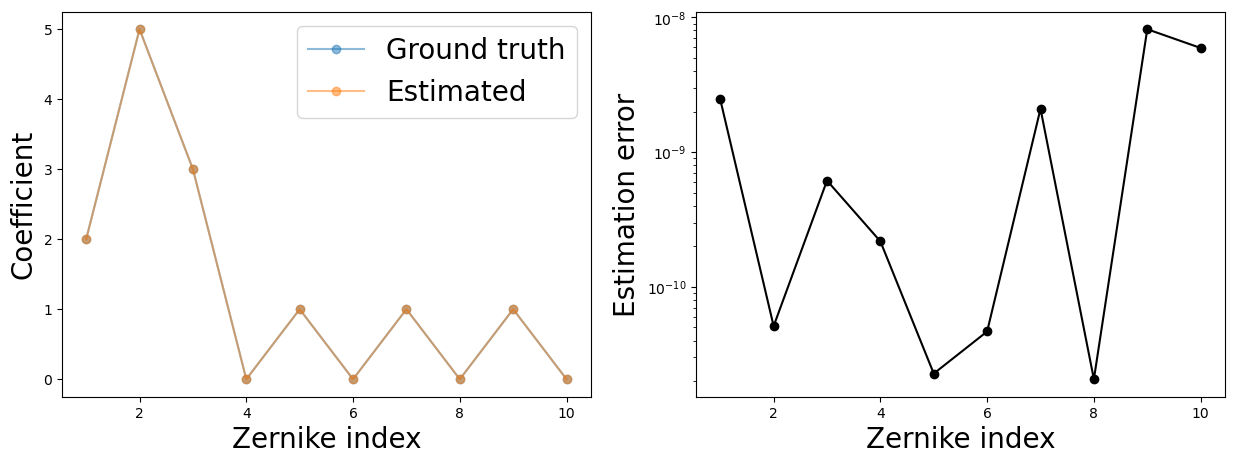

In [64]:
# Our final predicted coefficients
coefficients_estimated = jnp.abs(
    params["params"]["ZernikeAberrations_0"]["zernike_coefficients"]
)
print("Estimated coefficients:", coefficients_estimated)

coefficients_error = jnp.square(coefficients_estimated - coefficients_truth)
print("Coefficients error:", coefficients_error)

mean_coefficients_error = jnp.mean(
    jnp.square(coefficients_estimated - coefficients_truth)
)
print("Mean coefficients error:", mean_coefficients_error)

# Plots of ground truth, estimates and errors
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fontsize = 20
ax[0].plot(ansi_indices, coefficients_truth, "-o", label="Ground truth", alpha=0.5)
ax[0].plot(ansi_indices, coefficients_estimated, "-o", label="Estimated", alpha=0.5)
ax[0].set_xlabel("Zernike index", fontsize=fontsize)
ax[0].set_ylabel("Coefficient", fontsize=fontsize)
ax[0].legend(fontsize=fontsize)
ax[1].semilogy(ansi_indices, coefficients_error, "k-o")
ax[1].set_xlabel("Zernike index", fontsize=fontsize)
ax[1].set_ylabel("Estimation error", fontsize=fontsize)

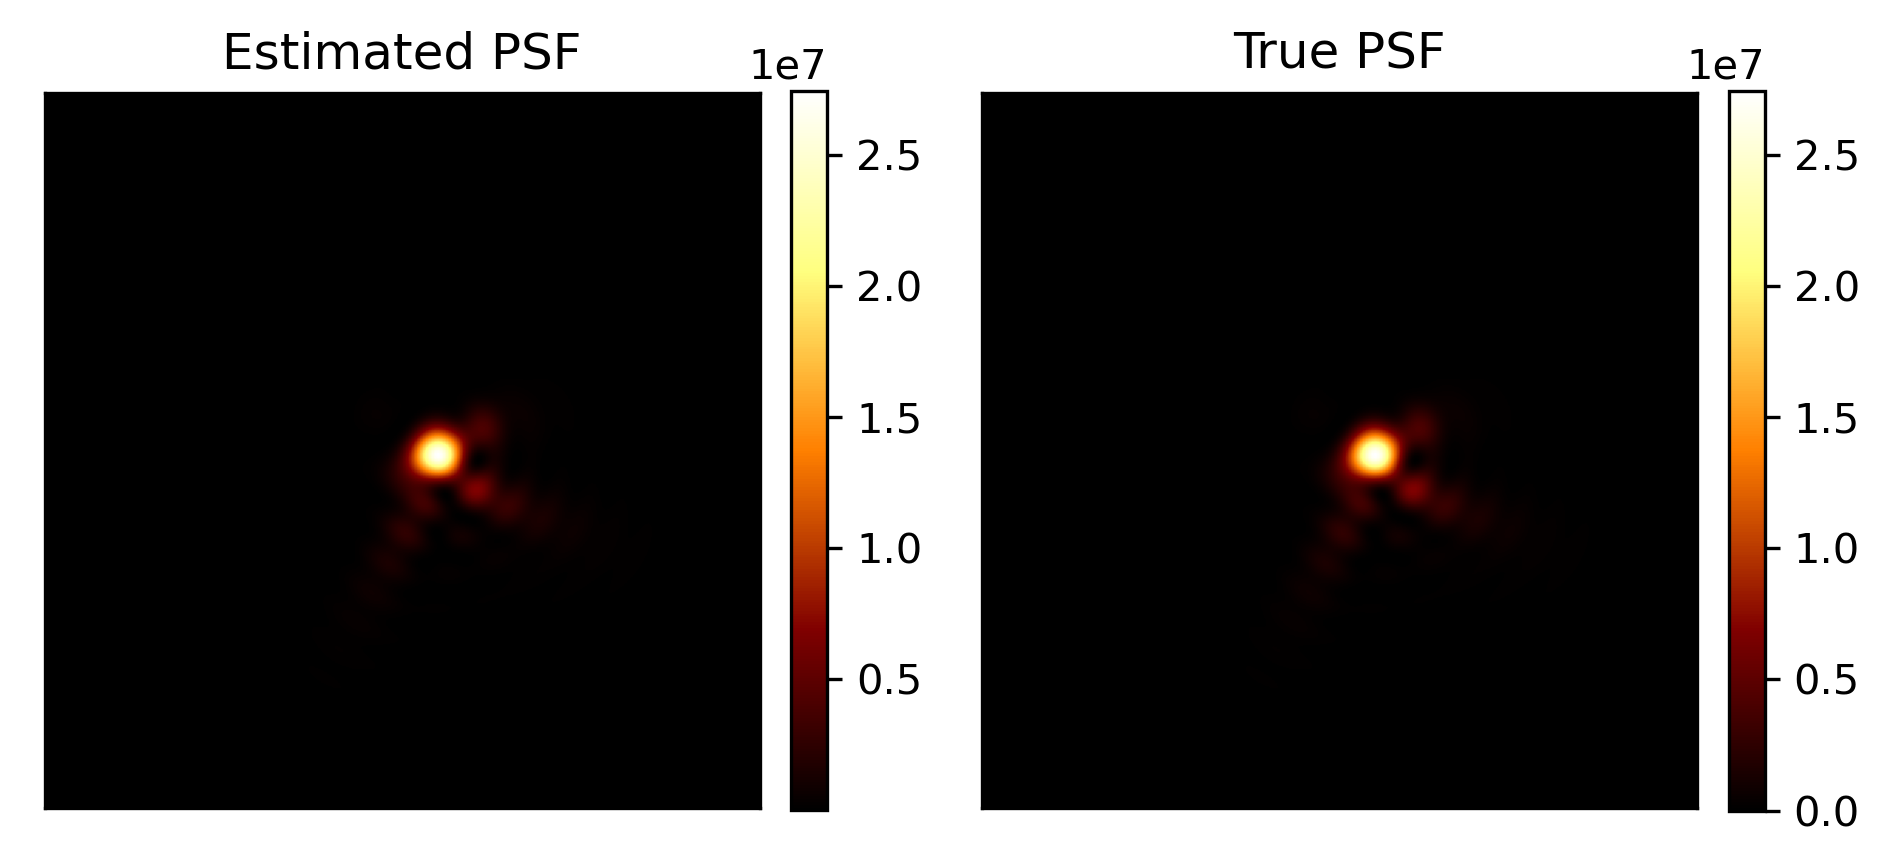

In [65]:
psf_estimated = model.apply(params, z=0).intensity.squeeze()

fig, ax = plt.subplots(1, 2, dpi=300)
m = ax[0].imshow(psf_estimated[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[0].title.set_text("Estimated PSF")
m = ax[1].imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[1].title.set_text("True PSF")
for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()